In [95]:
"""
Preprocessing code for EDoF-CNN using Fraunhofer database

X-> X_STACKS
Y-> Y_EDF (for each group of X_stacks)
"""


# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--Z', choices=[5], type=int, default=5)
# parser.add_argument('--folds', type=int, choices=range(5),default=5)
# parser.add_argument('--img_size', type=int, choices=[224,512],default=512)
# args = parser.parse_args()

class False_args(object):
    pass
args = False_args()
args.Z = 5
args.folds = 5
args.img_size = 512

import numpy as np
import pandas as pd
import glob
import cv2
import pickle
import os
import _pickle as cPickle
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from matplotlib import pyplot as plt
import glob
from os import listdir
from os.path import isfile, join, isdir



In [96]:
channel_3_pred_path=r"/home/van/research/EDoF-CNN/img_res/EDOF_CNN_pack_433channels/0/PRED_0.png"
gt_path=r"/home/van/research/EDoF-CNN/img_res/EDOF_CNN_pack_433channels/0/GT_0.png"
r_pred_path =r"/home/van/research/EDoF-CNN/img_res/EDOF_CNN_pack_43red/0/PRED_0.png"
g_pred_path =r"/home/van/research/EDoF-CNN/img_res/EDOF_CNN_pack_43green/0/PRED_0.png"
b_pred_path =r"/home/van/research/EDoF-CNN/img_res/EDOF_CNN_pack_43blue/0/PRED_0.png"

channel_3_pred_img = cv2.imread(channel_3_pred_path)
r_pred_img = cv2.imread(r_pred_path)
g_pred_img = cv2.imread(g_pred_path)
b_pred_img = cv2.imread(b_pred_path)
gt_img = cv2.imread(gt_path)

In [97]:
from PIL import Image

def convert_to_grayscale_arr(arr):
    gray_img = Image.fromarray(arr, 'RGB')
    gray_img = gray_img.convert('L')
    gray_img = np.array(gray_img)
    gray_img = np.expand_dims(gray_img,2)
    return gray_img

In [98]:
r_pred_img = convert_to_grayscale_arr(r_pred_img)
g_pred_img = convert_to_grayscale_arr(g_pred_img)
b_pred_img = convert_to_grayscale_arr(b_pred_img)

In [99]:
stacked = np.concatenate((r_pred_img,g_pred_img,b_pred_img), axis=2)
stacked.shape

(512, 512, 3)

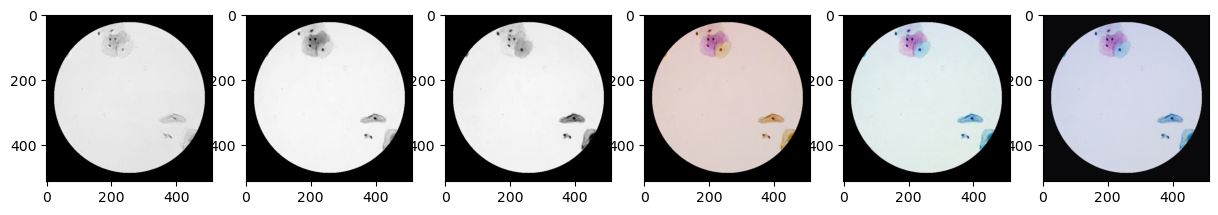

In [100]:
from skimage.util import random_noise
from matplotlib import pyplot as plt


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(15, 15))
ax1.imshow(r_pred_img, cmap='gray')
ax2.imshow(g_pred_img, cmap='gray')
ax3.imshow(b_pred_img, cmap='gray')
ax4.imshow(stacked, cmap='viridis')
ax5.imshow(gt_img, cmap='viridis')
ax6.imshow(channel_3_pred_img, cmap='viridis')

In [101]:
import numpy as np
from time import time
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import KFold
import torch
import dataset, models
from tqdm import tqdm
from PIL import Image

device = torch.device('cuda:'+str(0) if torch.cuda.is_available() else 'cpu')
args.dataset = "cervix93_zstacks"
args.fold = 0
args.Z = 5
args.method = "EDOF_CNN_pack_43"
args.epochs = 200
args.batchsize = 4

In [102]:
# print some metrics 
def predict_metrics(data, model):
    model.eval()
    Phat = []
    Y_true=[]
    input_list =[]
    with torch.no_grad():
        for XX, Y in data:
            XX = [X.to(device, torch.float) for X in XX]
            Y = Y.to(device, torch.float)
            Yhat = model(XX)
            # print(Yhat.shape)
            Phat += list(Yhat.cpu().numpy())
            Y_true += list(Y.cpu().numpy())
            numpy_list= []
            for x in XX:
                numpy_list+= list(x.cpu().numpy())
            input_list.append(numpy_list)
    return Y_true, Phat, input_list

def loadModel(image_channel):
    model = models.EDOF_CNN_pack_43()
    model.load_state_dict(torch.load("dataset-fraunhofer_elastic_only-image_size-512-method-"+args.method+"-Z-"+str(args.Z)+"-fold-"+str(args.fold)+"-epochs-"+str(args.epochs)+"-batchsize-"+str(args.batchsize)+"-lr-0.001-cudan-0-image_channels-"+image_channel+"-automate-1-augmentation-0-augmentLevel-0-rotate-0-hflip-0-ssim-0-jitter-1.pth"))
    model = model.to(device)
    return model

In [103]:
prefix = '-'.join(f'{k}-{v}' for k, v in vars(args).items())
print(prefix)
    ############################# data loaders #######################################

ts_ds = dataset.Dataset('test', dataset.val_transforms_rgb, args.dataset, args.Z, args.fold, dataset.val_transforms_rgb, dataset.common_transform_empty)
ts_ds_r = dataset.Dataset('test', dataset.aug_transforms_red, args.dataset, args.Z, args.fold, dataset.aug_transforms_red, dataset.common_transform_empty)
ts_ds_g = dataset.Dataset('test', dataset.aug_transforms_green, args.dataset, args.Z, args.fold, dataset.aug_transforms_green, dataset.common_transform_empty)
ts_ds_b = dataset.Dataset('test', dataset.aug_transforms_blue, args.dataset, args.Z, args.fold, dataset.aug_transforms_blue, dataset.common_transform_empty)


    #to view images
tst = DataLoader(ts_ds, 1,False,  pin_memory=True)

model_red = loadModel("red")
model_green = loadModel("green")
model_blue = loadModel("blue")
ensemble_model = models.EDOF_CNN_pack_ensemble(model_red,model_green,model_blue)

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, normalized_root_mse 


data_test = DataLoader(ts_ds, 1,False,  pin_memory=True)
data_test_r = DataLoader(ts_ds_r, 1,False,  pin_memory=True)
data_test_g = DataLoader(ts_ds_g, 1,False,  pin_memory=True)
data_test_b = DataLoader(ts_ds_b, 1,False,  pin_memory=True)
    # Y_true, Phat = predict_metrics(data_test,model_arr[0])
Y_true, Phat, X_list = predict_metrics(data_test,ensemble_model)
Y_true_r, Phat_r, X_list_r = predict_metrics(data_test_r, model_red)
Y_true_g, Phat_g, X_list_g = predict_metrics(data_test_g, model_green)
Y_true_b, Phat_b, X_list_b = predict_metrics(data_test_b, model_blue)

mean_list= [(i,mean_squared_error(Y_true[i], Phat[i])) for i in range(len(Y_true))]
rmse_list = [(i,normalized_root_mse(Y_true[i], Phat[i])) for i in range(len(Y_true))]
ssim_list = [(i,ssim(Y_true[i], Phat[i],channel_axis=0,data_range=1)) for i in range(len(Y_true))]
psnr_list = [(i,peak_signal_noise_ratio(Y_true[i], Phat[i])) for i in range(len(Y_true))]
mse = np.mean([mean_squared_error(Y_true[i], Phat[i]) for i in range(len(Y_true))])
rmse = np.mean([normalized_root_mse(Y_true[i], Phat[i]) for i in range(len(Y_true))])
ssim_ =np.mean([ssim(Y_true[i], Phat[i],channel_axis=0,data_range=1) for i in range(len(Y_true))]) 
psnr =np.mean([peak_signal_noise_ratio(Y_true[i], Phat[i]) for i in range(len(Y_true))])

    # view_images(model=model, tst=tst)



    # f = open('my_results_fixed_2/'+ str(prefix)+'.txt', 'a+')
    # f.write('\n\nModel:'+str(prefix)+
    #     ' \nMSE:'+ str(mse)+
    #     ' \nRMSE:'+ str(rmse)+
    #     ' \nSSIM:'+str(ssim)+
    #     ' \nPSNR:'+ str(psnr))
    # f.close()

print('my_results_fixed_1/'+ str(prefix)+'.txt')


Z-5-folds-5-img_size-512-dataset-cervix93_zstacks-fold-0-method-EDOF_CNN_pack_43-epochs-200-batchsize-4
my_results_fixed_1/Z-5-folds-5-img_size-512-dataset-cervix93_zstacks-fold-0-method-EDOF_CNN_pack_43-epochs-200-batchsize-4.txt


In [104]:
Phat[0].shape
model_image = Phat[0]
model_image = np.moveaxis(model_image,0,2)
model_image_r = np.expand_dims(model_image[:,:,0],2)
model_image_g = np.expand_dims(model_image[:,:,1],2)
model_image_b = np.expand_dims(model_image[:,:,2],2)

In [105]:
model_image_r.shape

(512, 512, 1)

In [106]:
model_stacked = np.concatenate((model_image_r,model_image_g,model_image_b), axis=2)
model_stacked.shape

(512, 512, 3)

In [107]:

sorted_mean_list = sorted(mean_list, key=lambda student: student[1])
sorted_rmse_list = sorted(rmse_list, key=lambda student: student[1])
sorted_ssim_list = sorted(ssim_list, key=lambda student: student[1])
sorted_psnr_list = sorted(psnr_list, key=lambda student: student[1])

In [108]:
sorted_ssim_list[-1][1]

0.6668803

In [109]:
# fig, axs = plt.subplots(4, 2, figsize=(15, 15))
# axs[0][0].imshow(np.moveaxis(Phat[sorted_rmse_list[-1][0]],0,2), cmap='viridis')
# axs[0][1].imshow(np.moveaxis(Y_true[sorted_rmse_list[-1][0]],0,2), cmap='viridis')
# axs[1][0].imshow(np.moveaxis(Phat[sorted_rmse_list[-2][0]],0,2), cmap='viridis')
# axs[1][1].imshow(np.moveaxis(Y_true[sorted_rmse_list[-2][0]],0,2), cmap='viridis')
# axs[2][0].imshow(np.moveaxis(Phat[sorted_rmse_list[0][0]],0,2), cmap='viridis')
# axs[2][1].imshow(np.moveaxis(Y_true[sorted_rmse_list[0][0]],0,2), cmap='viridis')
# axs[3][0].imshow(np.moveaxis(Phat[sorted_rmse_list[1][0]],0,2), cmap='viridis')
# axs[3][1].imshow(np.moveaxis(Y_true[sorted_rmse_list[1][0]],0,2), cmap='viridis')

In [110]:
# fig, axs = plt.subplots(4, 2, figsize=(15, 15))
# axs[0][0].imshow(np.moveaxis(Phat[sorted_psnr_list[0][0]],0,2), cmap='viridis')
# axs[0][1].imshow(np.moveaxis(Y_true[sorted_psnr_list[0][0]],0,2), cmap='viridis')
# axs[1][0].imshow(np.moveaxis(Phat[sorted_psnr_list[1][0]],0,2), cmap='viridis')
# axs[1][1].imshow(np.moveaxis(Y_true[sorted_psnr_list[1][0]],0,2), cmap='viridis')
# axs[2][0].imshow(np.moveaxis(Phat[sorted_psnr_list[-1][0]],0,2), cmap='viridis')
# axs[2][1].imshow(np.moveaxis(Y_true[sorted_psnr_list[-1][0]],0,2), cmap='viridis')
# axs[3][0].imshow(np.moveaxis(Phat[sorted_psnr_list[-2][0]],0,2), cmap='viridis')
# axs[3][1].imshow(np.moveaxis(Y_true[sorted_psnr_list[-2][0]],0,2), cmap='viridis')

In [111]:
# fig, axs = plt.subplots(4, 2, figsize=(15, 15))
# axs[0][0].imshow(np.moveaxis(Phat[sorted_ssim_list[0][0]],0,2), cmap='viridis')
# axs[0][1].imshow(np.moveaxis(Y_true[sorted_ssim_list[0][0]],0,2), cmap='viridis')
# axs[1][0].imshow(np.moveaxis(Phat[sorted_ssim_list[1][0]],0,2), cmap='viridis')
# axs[1][1].imshow(np.moveaxis(Y_true[sorted_ssim_list[1][0]],0,2), cmap='viridis')
# axs[2][0].imshow(np.moveaxis(Phat[sorted_ssim_list[-1][0]],0,2), cmap='viridis')
# axs[2][1].imshow(np.moveaxis(Y_true[sorted_ssim_list[-1][0]],0,2), cmap='viridis')
# axs[3][0].imshow(np.moveaxis(Phat[sorted_ssim_list[-2][0]],0,2), cmap='viridis')
# axs[3][1].imshow(np.moveaxis(Y_true[sorted_ssim_list[-2][0]],0,2), cmap='viridis')

In [112]:
from skimage.exposure import match_histograms

temp_list = []
for x in X_list:
    my_mean = np.array(x)
    my_mean = np.mean(my_mean, axis= 0, dtype=np.uint8)
    temp_list.append(my_mean)
ref_list = temp_list

color_transfered = []
for pred, ref in zip(Phat, ref_list):
    pred_reshape = np.moveaxis(pred,0,2)
    ref_reshape = np.moveaxis(ref,0,2)
    matched_histogram = match_histograms(pred_reshape, ref_reshape,channel_axis=-1)
    # col_transfered = colortrans.transfer_lhm(pred_reshape, ref_reshape)
    resume_shape = np.moveaxis(matched_histogram,2,0)
    color_transfered.append(resume_shape)

In [113]:
x = np.array(X_list[0])
x = np.mean(x, axis=0, dtype=np.uint8)
x.shape

(3, 512, 512)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


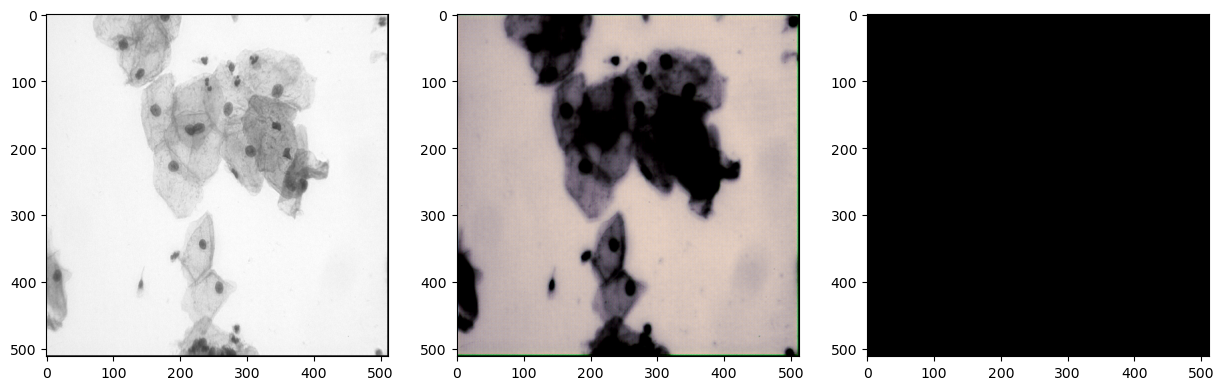

In [114]:
hundred_transfered = np.moveaxis(color_transfered[5],0,2)
hundred_gt = np.moveaxis(Y_true[5],0,2)
pred_img = np.moveaxis(Phat[5],0,2)
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(hundred_gt, cmap='viridis')
axs[1].imshow(pred_img, cmap='viridis')
axs[2].imshow(hundred_transfered, cmap='viridis')

In [115]:
X_list[sorted_psnr_list[1][0]][0].shape


(3, 512, 512)

In [116]:
gt_img = np.moveaxis(Y_true[sorted_psnr_list[1][0]],0,2)
pred_img = np.moveaxis(Phat[sorted_psnr_list[1][0]],0,2)
first_x_img = np.moveaxis(X_list[sorted_psnr_list[1][0]][0],0,2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


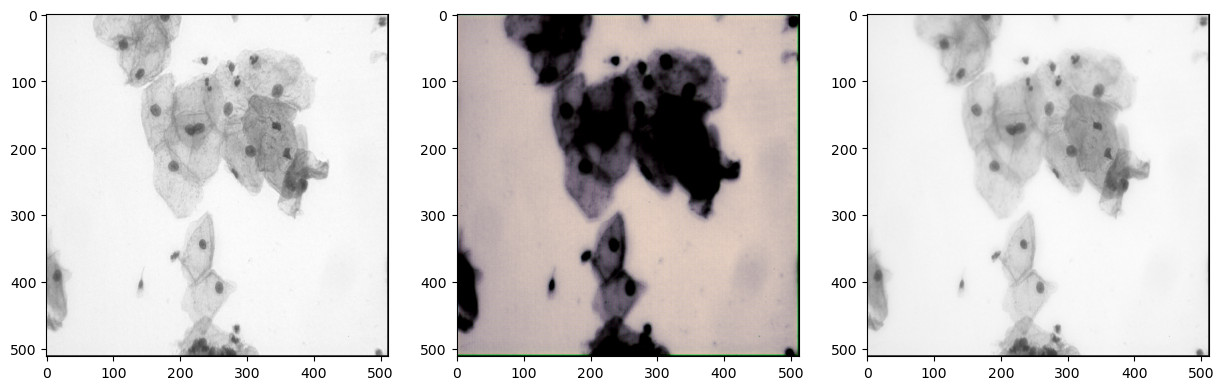

In [117]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(gt_img, cmap='viridis')
axs[1].imshow(pred_img, cmap='viridis')
axs[2].imshow(first_x_img, cmap='viridis')

In [118]:
def normalize8(I):
  mn = I.min()
  mx = I.max()

  mx -= mn

  I = ((I - mn)/mx) * 255
  return I.astype(np.uint8)

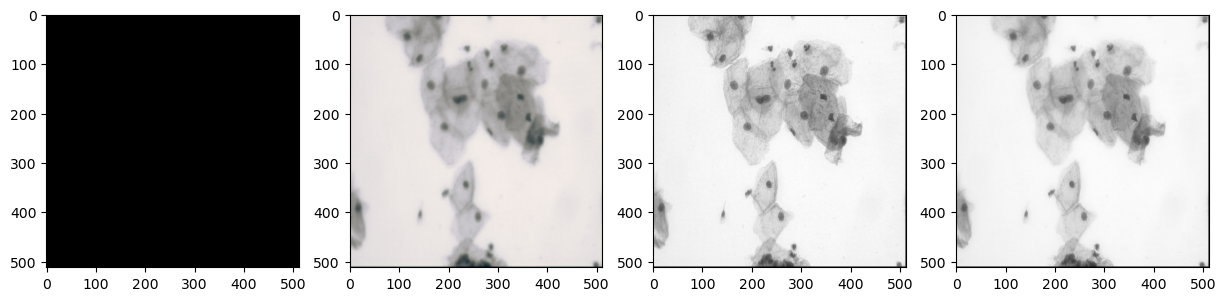

In [119]:
norm_pred_img = normalize8(pred_img)
norm_gt_img = normalize8(gt_img)
norm_x_img = normalize8(first_x_img)
output_lhm = colortrans.transfer_lhm(norm_pred_img, norm_gt_img)
output_lhm_input = colortrans.transfer_lhm(norm_pred_img, norm_x_img)
fig, axs = plt.subplots(1, 4, figsize=(15, 15))
axs[0].imshow(output_lhm, cmap='viridis')
axs[1].imshow(norm_pred_img, cmap='viridis')
axs[2].imshow(gt_img, cmap='viridis')
axs[3].imshow(norm_x_img, cmap='viridis')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


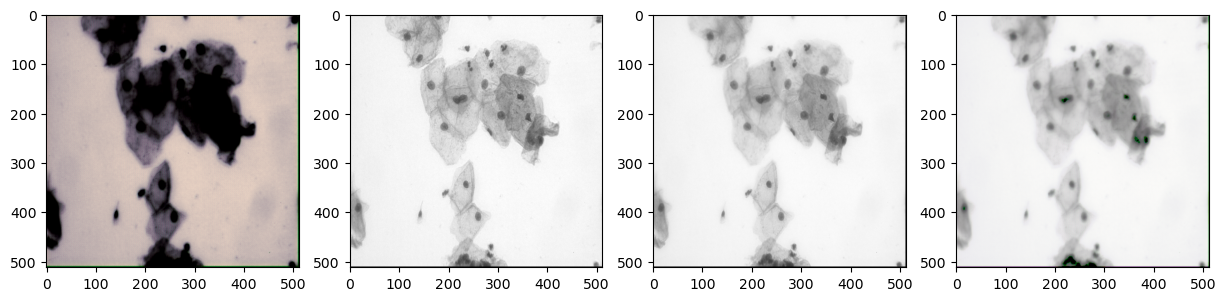

In [121]:
from skimage.exposure import match_histograms

matched_histogram = match_histograms(pred_img, first_x_img,channel_axis=-1)
fig, axs = plt.subplots(1, 4, figsize=(15, 15))
axs[0].imshow(pred_img, cmap='viridis')
axs[1].imshow(gt_img, cmap='viridis')
axs[2].imshow(first_x_img, cmap='viridis')
axs[3].imshow(matched_histogram, cmap='viridis')

In [62]:
mse_org = mean_squared_error(gt_img, pred_img)
rmse_org = normalized_root_mse(gt_img, pred_img) 
ssim_org = ssim(gt_img, pred_img,channel_axis=2,data_range=1)
psnr_org = peak_signal_noise_ratio(gt_img, pred_img)
print(str(mse_org) + " " + str(rmse_org) + " " + str(ssim_org) + " " + str(psnr_org))

0.1996178123780604 0.4955572104172802 0.43072817 6.998007081771641


In [63]:
mse_norm = mean_squared_error(norm_gt_img, norm_pred_img)
rmse_norm = normalized_root_mse(norm_gt_img, norm_pred_img) 
ssim_norm = ssim(norm_gt_img, norm_pred_img,channel_axis=2,data_range=1)
psnr_norm = peak_signal_noise_ratio(norm_gt_img, norm_pred_img)
print(str(mse_norm) + " " + str(rmse_norm) + " " + str(ssim_norm) + " " + str(psnr_norm))

319.4269879659017 0.07773914837203394 0.37602447673731315 23.087087545459703


In [64]:
mse_tran = mean_squared_error(norm_gt_img, output_lhm)
rmse_tran = normalized_root_mse(norm_gt_img, output_lhm) 
ssim_tran = ssim(norm_gt_img, output_lhm,channel_axis=2,data_range=1)
psnr_tran = peak_signal_noise_ratio(norm_gt_img, output_lhm)
print(str(mse_tran) + " " + str(rmse_tran) + " " + str(ssim_tran) + " " + str(psnr_tran))

52855.72679901123 1.0 2.4552719383244504e-13 0.8998831184569699


In [65]:
mse_tran = mean_squared_error(norm_gt_img, output_lhm_input)
rmse_tran = normalized_root_mse(norm_gt_img, output_lhm_input) 
ssim_tran = ssim(norm_gt_img, output_lhm_input,channel_axis=2,data_range=1)
psnr_tran = peak_signal_noise_ratio(norm_gt_img, output_lhm_input)
print(str(mse_tran) + " " + str(rmse_tran) + " " + str(ssim_tran) + " " + str(psnr_tran))

52855.72679901123 1.0 2.4552719383244504e-13 0.8998831184569699


In [66]:
import colortrans


Y_true_norm = list(map(normalize8,Y_true))
Phat_norm = list(map(normalize8,Phat))
color_transfered = []
for pred, gt in zip(Phat_norm, Y_true_norm):
    pred_reshape = np.moveaxis(pred,0,2)
    gt_reshape = np.moveaxis(gt,0,2)
    col_transfered = colortrans.transfer_lhm(pred_reshape, gt_reshape)
    resume_shape = np.moveaxis(col_transfered,2,0)
    color_transfered.append(resume_shape)
Phat_trans = color_transfered

mean_list_trans= [(i,mean_squared_error(Y_true_norm[i], Phat_trans[i])) for i in range(len(Y_true_norm))]
rmse_list_trans = [(i,normalized_root_mse(Y_true_norm[i], Phat_trans[i])) for i in range(len(Y_true_norm))]
ssim_list_trans = [(i,ssim(Y_true_norm[i], Phat_trans[i],channel_axis=0,data_range=255)) for i in range(len(Y_true_norm))]
psnr_list_trans = [(i,peak_signal_noise_ratio(Y_true_norm[i], Phat_trans[i])) for i in range(len(Y_true_norm))]

In [67]:
gt_img = np.moveaxis(Y_true_norm[0],0,2)
pred_img = np.moveaxis(Phat_trans[0],0,2)

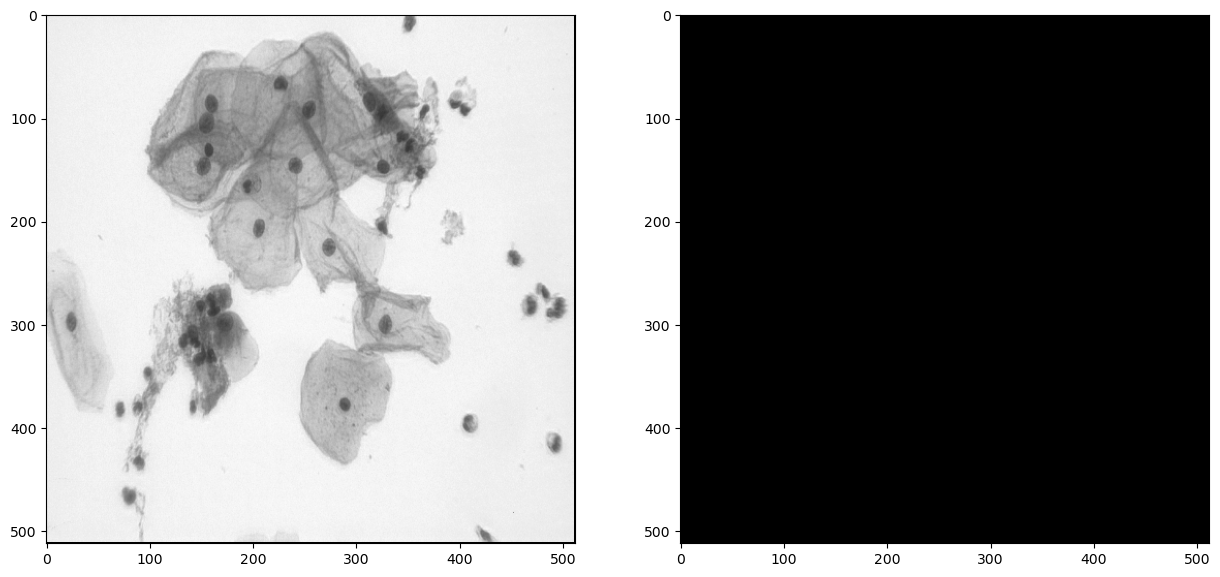

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(gt_img, cmap='viridis')
axs[1].imshow(pred_img, cmap='viridis')